Import necessary libraries

In [1]:
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import MinMaxScaler  # For normalizing data
from tensorflow.keras.models import Sequential  # For defining the LSTM model
from tensorflow.keras.layers import LSTM, Dense  # LSTM and Dense layers
from tensorflow.keras.optimizers import Adam  # Optimizer for gradient descent

Generate synthetic stock price data

In [2]:
np.random.seed(42)
time_steps = 100  # Number of time steps
price = np.cumsum(np.random.randn(time_steps) * 2) + 100  # Simulating stock prices using a random walk

df = pd.DataFrame(price, columns=["Stock Price"])  # Creating a DataFrame

Visualizing the stock price data

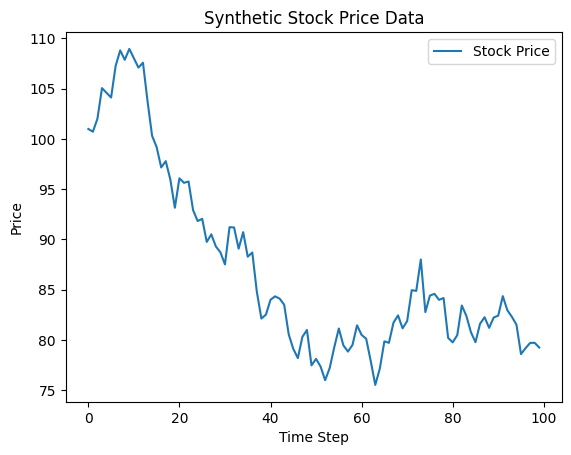

In [3]:
plt.plot(df, label='Stock Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Synthetic Stock Price Data')
plt.legend()
plt.show()

Prepare data for LSTM

In [4]:
# Normalize the data to scale between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

# Prepare data for LSTM
X, y = [], []
n_steps = 10  # Number of previous time steps to consider

Long Short-Term Memory (LSTM) processes sequential data by maintaining a memory state:

    The LSTM cell consists of three gates:
        1. Forget Gate: f_t = σ(W_f * [h_(t-1), x_t] + b_f)
        2. Input Gate: i_t = σ(W_i * [h_(t-1), x_t] + b_i)
        3. Output Gate: o_t = σ(W_o * [h_(t-1), x_t] + b_o)
    The cell state is updated as:
        C_t = f_t * C_(t-1) + i_t * tanh(W_c * [h_(t-1), x_t] + b_c)
    The hidden state is updated as:
        h_t = o_t * tanh(C_t)

In [5]:
for i in range(len(data_scaled) - n_steps):
    X.append(data_scaled[i:i + n_steps])  # Input sequence of length 'n_steps'
    y.append(data_scaled[i + n_steps])  # Corresponding output

X, y = np.array(X), np.array(y)

Split data into training and testing sets

In [6]:
split_ratio = 0.8  # 80% training, 20% testing
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Define the LSTM model

In [7]:
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),  # LSTM layer with 50 units
    # The activation function tanh is defined as:
    # tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
    # It helps maintain gradients and avoid vanishing gradient problems.
    Dense(1)  # Output layer with a single neuron for price prediction
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile and train the model

In [8]:
# Compile the model
# The loss function used is Mean Squared Error (MSE):
# MSE = (1/n) * Σ (y_true - y_pred)^2
# where n is the number of samples
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0352 - val_loss: 0.0022
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0101 - val_loss: 0.0024
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - val_loss: 0.0024
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049 - val_loss: 0.0020
E

Predict on the test set

In [9]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Plot actual vs predicted stock prices

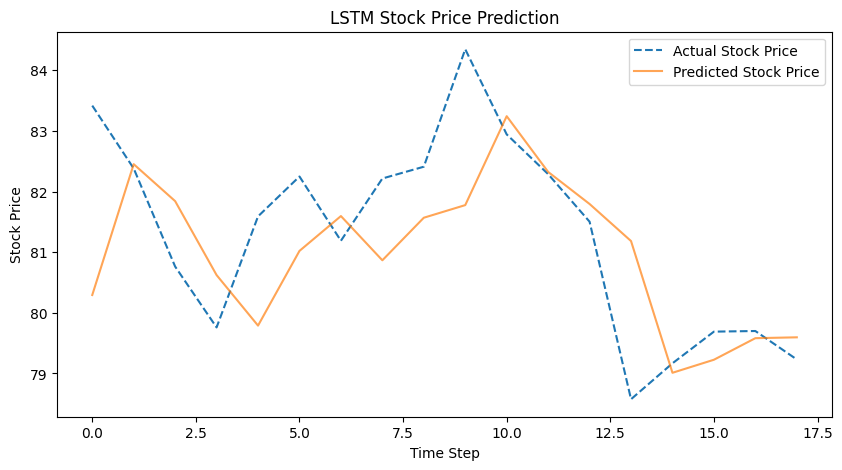

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label='Actual Stock Price', linestyle='dashed')
plt.plot(y_pred_actual, label='Predicted Stock Price', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title('LSTM Stock Price Prediction')
plt.legend()
plt.show()